# Predictive Maintenance - A Primer
**Predictive maintenance** is a proactive maintenance strategy that uses data analysis, machine learning algorithms, and sensor data to predict when equipment or machinery is likely to fail. By analysing historical data, monitoring current conditions, and employing algorithms to forecast potential failures, organisations can schedule maintenance activities in advance, reducing downtime, optimising resources, and preventing costly breakdowns.

In this project, we will be introducing the concept of predictive maintenance, however, we will keep it simple and focus on the basics. The dataset is pretty simple but sufficient to enable us to predict if the machine has failed or not, as well as allow us to classify the machine's failure mode. A more complete predictive maintenance project will involve more complex datasets and models, such as the ability to predict a machine's **Remaining Useful Life (RUL)**. However, we will not be covering that in this project.

## The Dataset
- Dataset: [Predictive Maintenance Dataset (AI4I 2020)](https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020)

This synthetic dataset is modelled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

1. **UID**: unique identifier ranging from 1 to 10000
1. **product ID**: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
1. **type**: just the product type L, M or H from column 2
1. **air temperature [K]**: generated using a random walk process later normalised to a standard deviation of 2 K around 300 K
1. **process temperature [K]**: generated using a random walk process normalised to a standard deviation of 1 K, added to the air temperature plus 10 K.
1. **rotational speed [rpm]**: calculated from a power of 2860 W, overlaid with a normally distributed noise
1. **torque [Nm]**: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
1. **tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
1. **a 'machine failure' label** that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

1. **tool wear failure (TWF)**: the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
1. **heat dissipation failure (HDF)**: heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
1. **power failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
1. **overstrain failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
1. **random failures (RNF)**: each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

This dataset is part of the following publication, please cite when using this dataset:
S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.


In [1]:
!pip install --upgrade pip
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scikit-learn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
FOLDER="data"
DATAFILE="data.csv"

sensors_df=pd.read_csv(f"{FOLDER}/{DATAFILE}", header=0)

sensors_copy_df = sensors_df.copy()
sensors_copy_df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


### Check for nulls, data types, and number of rows and columns


In [4]:
sensors_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### Check descriptive statistics

In [5]:
sensors_copy_df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### Assumptions to check in logistic regression:
- linearity (is the data linear?)
- normality (is the data normally distributed?)
- homoscedasticity (does that data have uniform scatter?)
- independence (are the input variable collinear?)

Text(0.5, 1.05, 'Pairplot of sensor date')

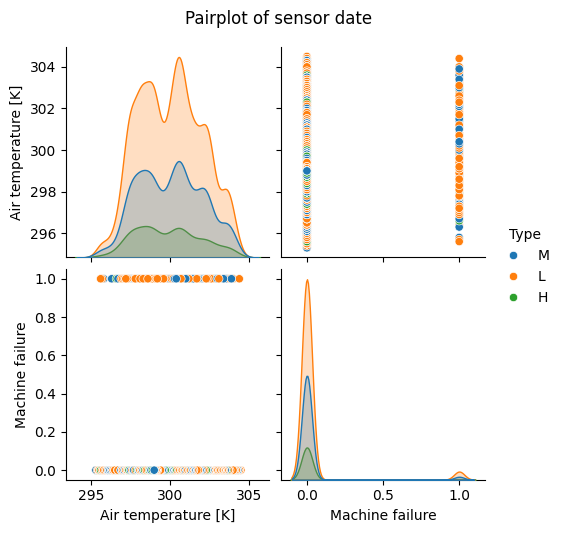

In [6]:
plot = sns.pairplot(sensors_copy_df[["Type",
                                     "Air temperature [K]",
                                    #  "Process temperature [K]",
                                    #  "Rotational speed [rpm]",
                                    #  "Torque [Nm]",
                                    #  "Tool wear [min]",
                                     "Machine failure"]], hue="Type")
plot.figure.suptitle("Pairplot of sensor date", y=1.05)

### Check data skewness

In [7]:
sensors_copy_df[["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]].skew()

Air temperature [K]        0.114274
Process temperature [K]    0.015027
Rotational speed [rpm]     1.993171
Torque [Nm]               -0.009517
Tool wear [min]            0.027292
dtype: float64

### Confirm the skewness by plotting the data
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical

- If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed

- If the skewness is less than -1 or greater than 1, the data are highly skewed

array([[<Axes: title={'center': 'Air temperature [K]'}>,
        <Axes: title={'center': 'Process temperature [K]'}>],
       [<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>],
       [<Axes: title={'center': 'Tool wear [min]'}>, <Axes: >]],
      dtype=object)

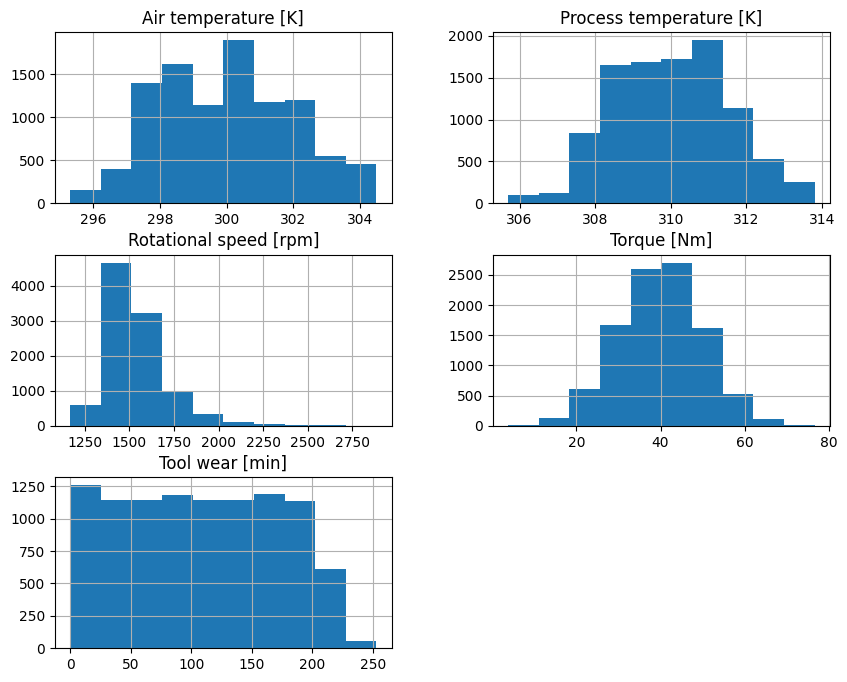

In [8]:
sensors_copy_df[["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]].hist(figsize=(10, 8))


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

X = sensors_copy_df[["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]]
y = sensors_copy_df[["Machine failure"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, stratify=y, random_state=42)
X_train_scaled = scale.fit_transform(X_train)

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

/Users/josereyes/Dev/predictive-maintenance/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [22]:
y_pred_train = logreg.predict(X_train_scaled)
train_score = logreg.score(X_train_scaled, y_train)
print(f"Accuracy of logistic regression classifier on train set: {train_score:.2%}")

Accuracy of logistic regression classifier on train set: 97.10%


In [23]:
X_test_scaled = scale.transform(X_test)

y_pred_test = logreg.predict(X_test_scaled)
test_score = logreg.score(X_test_scaled, y_test)
print(f"Accuracy of logistic regression classifier on test set: {test_score:.2%}")

Accuracy of logistic regression classifier on test set: 96.92%
